### Visualizing NeuroTycho monkey anesthesia results

In [62]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

import neurodsp as ndsp
from fooof import FOOOFGroup
from scv_funcs import lfpca
from scv_funcs import utils
from scv_funcs import access_nt as asc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
saveout_path = "../results/nt/"
lfpca_files = sorted([f for f in os.listdir(saveout_path) if 'lfpca' in f])
fooof_files = sorted([f for f in os.listdir(saveout_path) if 'fooof' in f])

### visualizing SCV/Exponential fitness under different brain states

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


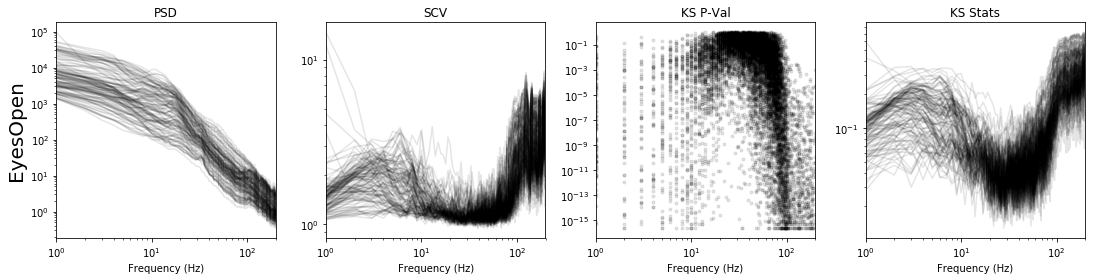

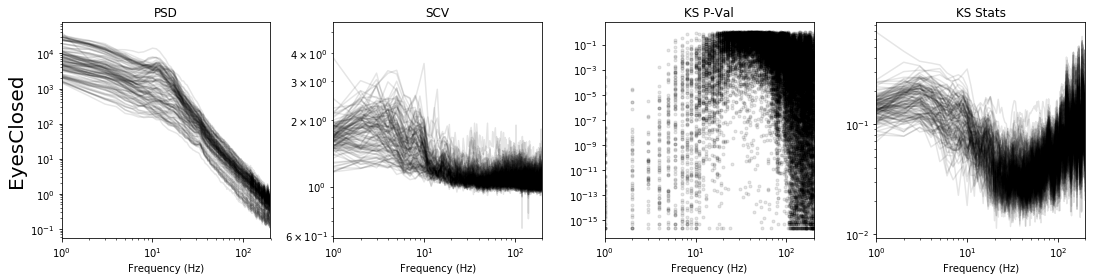

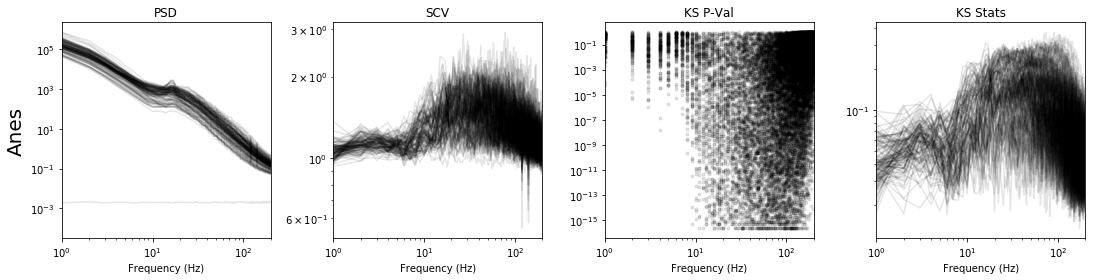

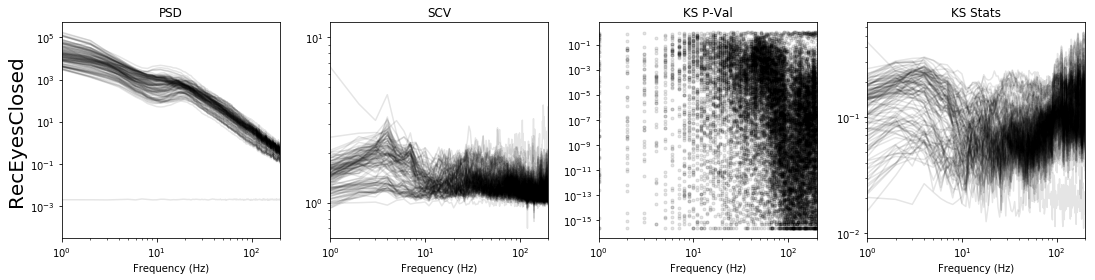

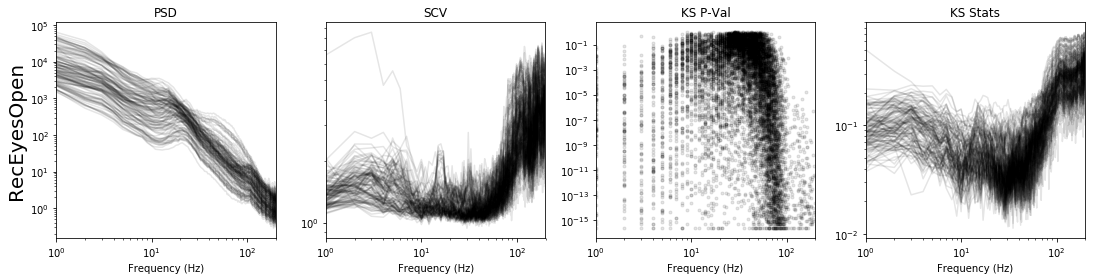

In [99]:
lfpca_all = []
for f in range(len(lfpca_files)):
    nt_lfpca = lfpca_load_spec(saveout_path+lfpca_files[f])
    lfpca_all.append(nt_lfpca)
    plt.figure(figsize=(15,4))
    nt_lfpca.plot_spectral(plot_mean=False)
    plt.subplot(1,4,1)
    plt.ylabel(lfpca_files[f][10:-4], fontsize=20)


### observations:
- resting and recovery periods have qualitatively similar SCVs and PSDs, with the exception of some oscillations
- in all but ANES conditions, low and high frequencies exhibit burst-like behavior, and the middle range (30-70Hz) is noise-like. This is the opposite for the anesthesia condition, where the middle range has higher variability than predicted
- it's possible that the anesthesia state is actually non-stationary, i.e. entering vs. maintenance of deep anesthesia. Should look into the temporal dynamics.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


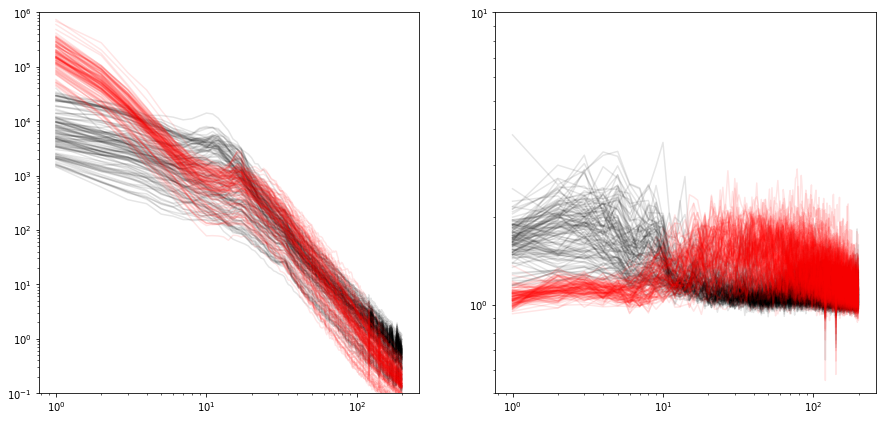

In [104]:
plot_conds = [1,2]
plot_colors = ['k', 'r', 'b']
plt.figure(figsize=(15,7))
for i, cond in enumerate(plot_conds):
    plt.subplot(1,2,1)
    plt.loglog(lfpca_all[cond].f_axis, lfpca_all[cond].psd.T, color=plot_colors[i], alpha=0.1)
    plt.ylim([1e-1, 1e6])
    plt.subplot(1,2,2)
    plt.loglog(lfpca_all[cond].f_axis, lfpca_all[cond].scv.T, color=plot_colors[i], alpha=0.1)
    plt.ylim([0.5, 10])
    plt.legend()


In [86]:
# reprocess eyes closed condition data
session_inds = (1,2,3)
chan = range(1,129)
indices = asc.get_cond(data_path, session_inds[0], session_inds[1], session_inds[2])
data = asc.get_ECoG(data_path, session_inds[0], chan, indices)
ec_lfpca = lfpca_all[0]
ec_lfpca.populate_ts_data(data,fs=1000)
ec_lfpca.compute_all_spectral()

# reprocess anesthesia condition data
session_inds = (2,1,2)
indices = asc.get_cond(data_path, session_inds[0], session_inds[1], session_inds[2])
data = asc.get_ECoG(data_path, session_inds[0], chan, indices)
an_lfpca = lfpca_all[2]
an_lfpca.populate_ts_data(data,fs=1000)
an_lfpca.compute_all_spectral()

AwakeEyesClosed-Start AwakeEyesClosed-End
Anesthetized-Start Anesthetized-End
Handling run-time error: Did not fully consume compressed contents of an miCOMPRESSED element. This can indicate that the .mat file is corrupted.
Channel 63 is filled in with white noise.


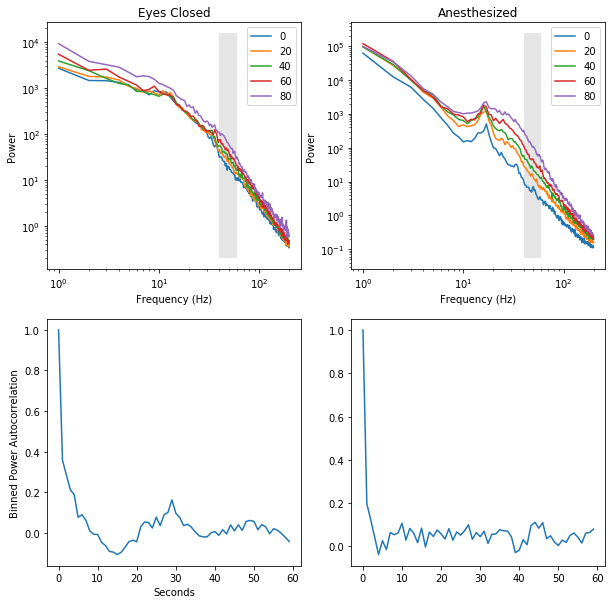

In [123]:
plot_chan = 40 #10,100
rank_freqs=(40,60)
pct=range(0,100,20)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
ec_pwr_dgt = utils.percentile_spectrogram(ec_lfpca.spg[plot_chan,:,:], ec_lfpca.f_axis, rank_freqs, pct);
plt.title('Eyes Closed')
plt.subplot(2,2,3)
plt.plot(utils.autocorr(ec_pwr_dgt, 60)[1])
plt.xlabel('Seconds')
plt.ylabel('Binned Power Autocorrelation')

plt.subplot(2,2,2)
an_pwr_dgt = utils.percentile_spectrogram(an_lfpca.spg[plot_chan,:,:], an_lfpca.f_axis, rank_freqs, pct);
plt.title('Anesthesized')
plt.subplot(2,2,4)
plt.plot(utils.autocorr(an_pwr_dgt, 60)[1])

# broadband fluctuations under anesthesia
- it appears that there are actually broadband (multi-frequency correlated) power fluctuations under anesthesia, which violates the noise exponential null hypothesis, but that is not the case in eyes-closed resting.
- however, the fluctuation during anesthesia has no autocorrelation in the time domain, which implies that the power fluctuation is stochastic, whereas it has temporal structure during eyes closed resting, on the order of 30 seconds.

### FOOOF results

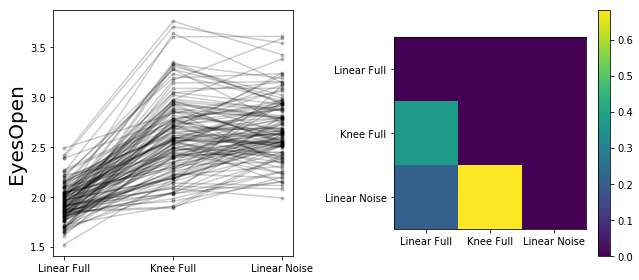

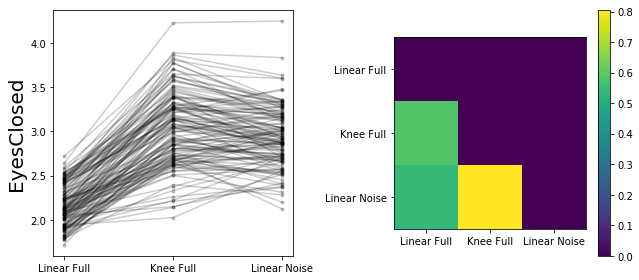

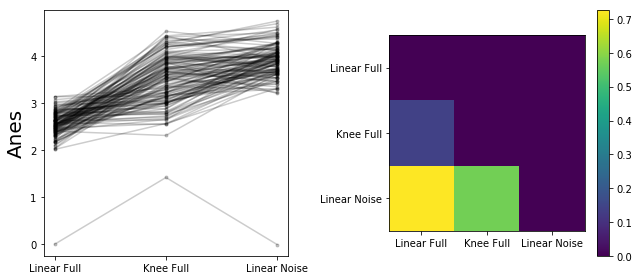

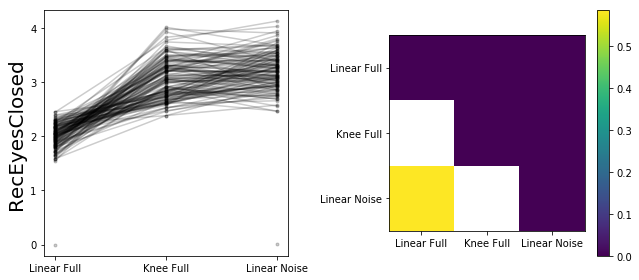

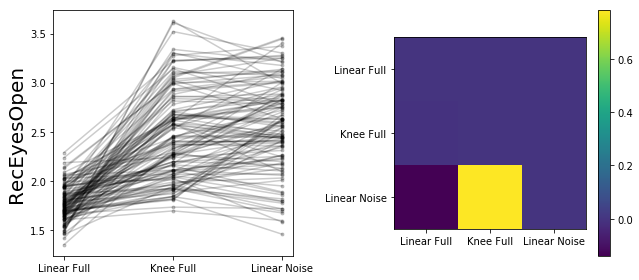

In [37]:
for ind, f in enumerate(fooof_files):
    fooof_data = np.load(saveout_path+f)
    #slope knee r2
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(fooof_data['fooof_res'][:,0,:].T,'.-k', alpha=0.2)
    plt.ylabel(lfpca_files[ind][10:-4], fontsize=20)
    plt.xticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))
    plt.subplot(1,2,2)    
    plt.imshow(np.tril(np.corrcoef(fooof_data['fooof_res'][:,0,:].T),k=-1))
    plt.colorbar()
    plt.xticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))    
    plt.yticks(range(3), ('Linear Full', 'Knee Full', 'Linear Noise'))
    plt.tight_layout()

### fooof observations
- in general, 1/f exponent derived from fitting the full range (3-100Hz) with knee (i.e. Lorentzian function) is more correlated with exponent fit in the noise region (30-70Hz), except, it seems, the anesthesia state